# Simulation & Rescheduling nach einem Tag (Regeneration)

In [1]:
import json
import pandas as pd
import numpy as np
import random

pd.set_option('display.max_rows', 30)

In [2]:
# Basics
import utils.basics.presenter as show
import utils.basics.converter as convert

import utils.checker as check
import utils.rolling_planning as rp
import utils.schedule_interarrival as sit

from ProductionDaySimulation import ProductionDaySimulation

In [3]:
import utils.schedule_solver__arrival as ssv_a
import utils.reschedule.schedule_solver__arrival as rssv_a

In [4]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)

In [5]:
df_jssp, df_times = rp.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax= 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [6]:
df_times

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
33,Job_033,2630.89
34,Job_034,2637.28
35,Job_035,2638.72
36,Job_036,2764.04


In [7]:
solver_limit = 60*60*4

## I) Complete Scheduling

In [8]:
df_plan = ssv_a.solve_jssp_individual_flowtime(df_jssp, df_times, solver_time_limit = solver_limit)
df_plan

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 14400
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/81a8dad7fccf4fa789852ee7407c3b12-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/81a8dad7fccf4fa789852ee7407c3b12-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 7030
MIP  81a8dad7fccf4fa789852ee7407c3b12-pulp has 14478 rows; 7448 cols; 42978 nonzeros; 7030 integer variables (7030 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+06]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+06]
Presolving model
14402 rows, 7410 cols, 42864 nonzeros  0s
7372 rows, 7410 cols, 21774 nonzeros  0s
7372 rows, 7410 cols, 21774 nonzeros  0s

Solving MIP model with:
   7372 rows
   7410 cols (7030 binary, 0 integer, 0 implied int., 380 continuous)
   21774 nonzeros

Src: B => Branching; C => Central rounding;

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
375,Job_037,5,2869.61,M9,3503.39,76,709.78,3579.39
376,Job_037,6,2869.61,M5,3579.39,47,756.78,3626.39
377,Job_037,7,2869.61,M3,3626.39,52,808.78,3678.39
378,Job_037,8,2869.61,M4,3678.39,90,898.78,3768.39


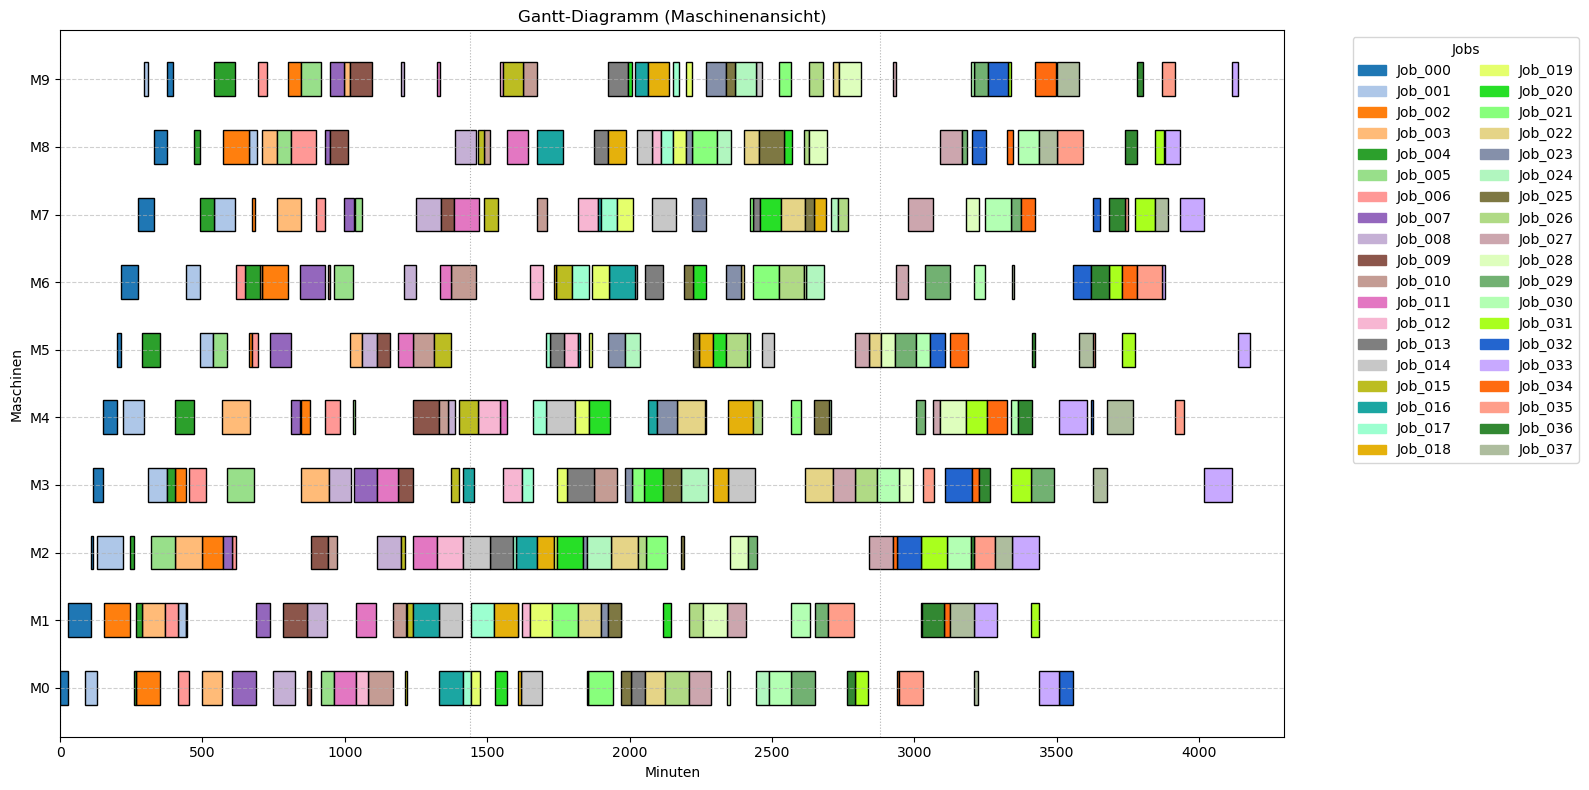

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [9]:
show.plot_gantt_machines(df_plan)
check.check_all_constraints(df_plan)

## II) First Day

### a) Simulation

In [10]:
day_start = 0
day_end = day_start + 1440

filt = (df_plan["Start"] >=  day_start) & (df_plan["Start"] < day_end)
df_schedule_day = df_plan[filt]
df_schedule_day

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
155,Job_015,5,1197.28,M4,1399.39,69,271.11,1468.39
160,Job_016,0,1198.72,M1,1239.39,91,131.67,1330.39
161,Job_016,1,1198.72,M0,1330.39,85,216.67,1415.39
162,Job_016,2,1198.72,M3,1415.39,39,255.67,1454.39


In [11]:
simulation = ProductionDaySimulation(df_schedule_day, vc=0.42)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:11:16] Job_000 finished on M0 (after 11 minutes 17 seconds)
[00:29:00] Job_000 started on M1
[01:28:02] Job_001 started on M0
[01:32:45] Job_000 finished on M1 (after 63 minutes 45 seconds)
[01:47:00] Job_000 started on M2
[01:53:00] Job_000 finished on M2 (after 06 minutes)
[01:56:00] Job_000 started on M3
[02:02:01] Job_001 finished on M0 (after 33 minutes 58 seconds)
[02:11:03] Job_001 started on M2
[02:32:46] Job_002 started on M1
[02:48:44] Job_000 finished on M3 (after 52 minutes 44 seconds)
[02:48:44] Job_000 started on M4
[03:30:08] Job_000 finished on M4 (after 41 minutes 24 seconds)
[03:30:08] Job_000 started on M5
[03:45:12] Job_000 finished on M5 (after 15 minutes 04 seconds)
[03:45:12] Job_000 started on M6
[04:11:19] Job_002 finished on M1 (after 98 minutes 32 seconds)
[04:26:36] Job_002 started on M0
[04:34:34] Job_000 finished on M6 (after 49 minutes 23 seconds)
[04:34:34] Job_000 started on M7
[04:35:59] Job_001 finished on M2 (afte

In [12]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_009,8,781.95,M4,1239.39,90
8,Job_015,3,1197.28,M5,1312.39,61
4,Job_011,5,944.71,M9,1323.39,11
2,Job_010,4,891.94,M4,1329.39,32
5,Job_011,6,944.71,M6,1334.39,40
1,Job_009,9,781.95,M7,1337.39,45
9,Job_015,4,1197.28,M3,1373.39,26
3,Job_010,5,891.94,M6,1374.39,88
6,Job_011,7,944.71,M7,1382.39,89
10,Job_015,5,1197.28,M4,1399.39,69


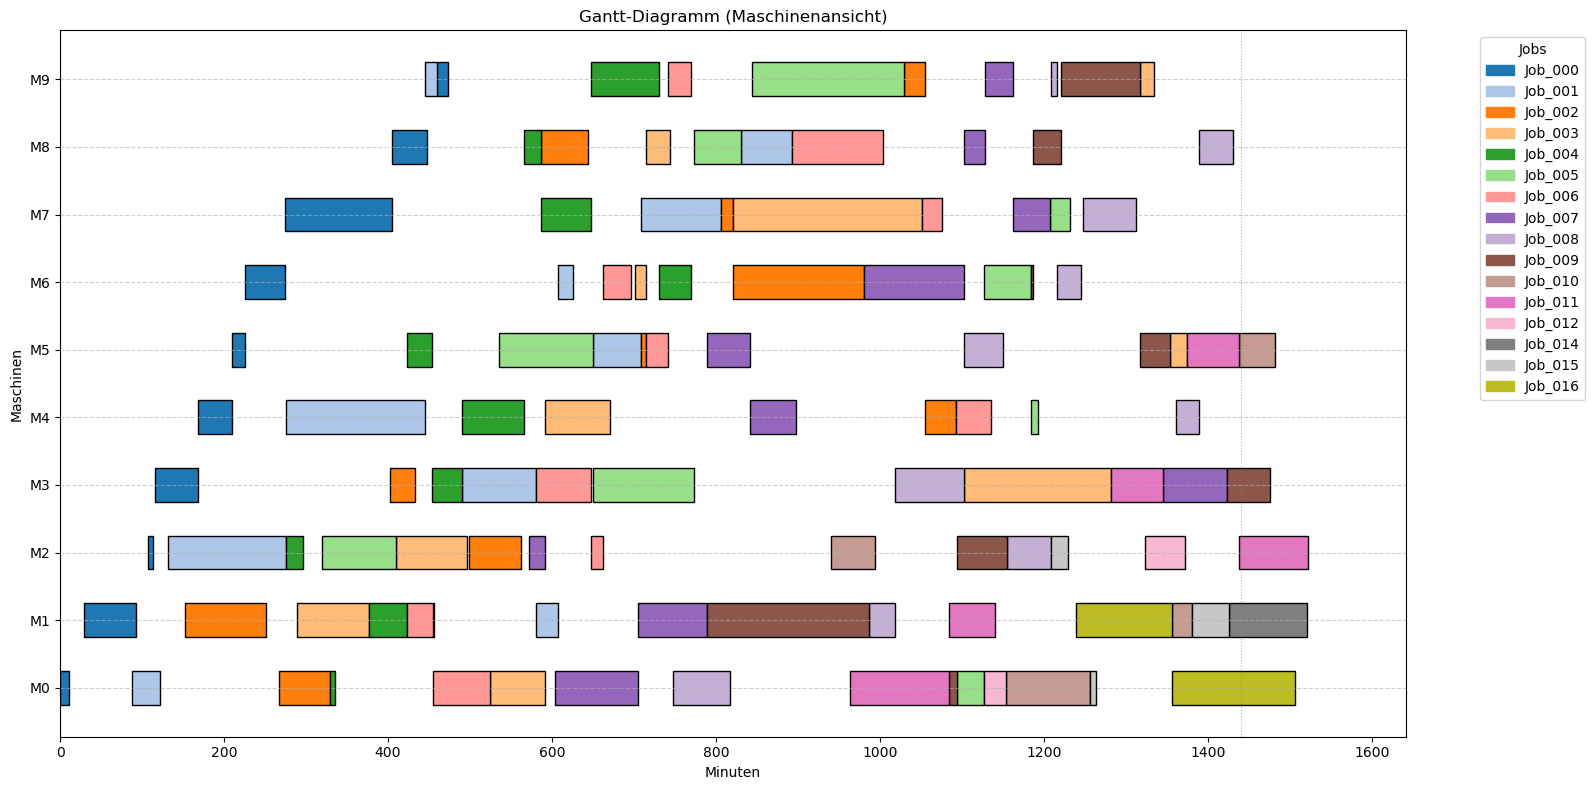

In [13]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### b) Verbleibene Jobs (Rest)

In [14]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_009,8,781.95,M4,1239.39,90,547.44,1329.39
1,Job_009,9,781.95,M7,1337.39,45,600.44,1382.39
2,Job_010,4,891.94,M4,1329.39,32,469.45,1361.39
3,Job_010,5,891.94,M6,1374.39,88,570.45,1462.39
4,Job_010,6,891.94,M8,1489.39,19,616.45,1508.39
...,...,...,...,...,...,...,...,...
260,Job_037,5,2869.61,M9,3503.39,76,709.78,3579.39
261,Job_037,6,2869.61,M5,3579.39,47,756.78,3626.39
262,Job_037,7,2869.61,M3,3626.39,52,808.78,3678.39
263,Job_037,8,2869.61,M4,3678.39,90,898.78,3768.39


In [15]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival
9,Job_009,781.95
10,Job_010,891.94
11,Job_011,944.71
12,Job_012,1003.56
13,Job_013,1185.73
14,Job_014,1190.89
15,Job_015,1197.28
16,Job_016,1198.72
17,Job_017,1324.04
18,Job_018,1429.61


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [16]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
97,Job_009,7,781.95,M3,1423.89,51.85,693.79,1475.74
101,Job_010,3,891.94,M5,1438.57,43.73,590.36,1482.30
106,Job_011,4,944.71,M2,1438.57,83.32,577.18,1521.89
109,Job_014,0,1190.89,M1,1426.28,94.73,330.12,1521.01
114,Job_016,1,1198.72,M0,1356.81,150.16,308.25,1506.97


In [17]:
df_reschedule = rssv_a.solve_jssp_individual_flowtime_with_fixed_ops(
    df_rest, df_time_rest, df_execution_important, 
    solver_time_limit = solver_limit, arrival_column = "Arrival",
    reschedule_start = 1440
)

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 14400
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/f1adf74f9e2b4a36accb4db3e1e3f327-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/f1adf74f9e2b4a36accb4db3e1e3f327-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 3527
MIP  f1adf74f9e2b4a36accb4db3e1e3f327-pulp has 7348 rows; 3821 cols; 21475 nonzeros; 3527 integer variables (3527 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
7248 rows, 3744 cols, 21250 nonzeros  0s
4556 rows, 3742 cols, 13286 nonzeros  0s
4504 rows, 3716 cols, 13182 nonzeros  0s

Solving MIP model with:
   4504 rows
   3716 cols (3451 binary, 0 integer, 0 implied int., 265 continuous)
   13182 nonzeros

Src: B => Branching; C => Central rounding; F

In [18]:
df_reschedule

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_009,8,781.95,M4,1475.87,90.0,783.92,1565.87
1,Job_009,9,781.95,M7,1565.87,45.0,828.92,1610.87
2,Job_010,4,891.94,M4,1709.87,32.0,849.93,1741.87
3,Job_010,5,891.94,M6,1741.87,88.0,937.93,1829.87
4,Job_010,6,891.94,M8,1968.01,19.0,1095.07,1987.01
...,...,...,...,...,...,...,...,...
260,Job_037,5,2869.61,M9,3421.61,76.0,628.00,3497.61
261,Job_037,6,2869.61,M5,3497.61,47.0,675.00,3544.61
262,Job_037,7,2869.61,M3,3544.61,52.0,727.00,3596.61
263,Job_037,8,2869.61,M4,3596.61,90.0,817.00,3686.61


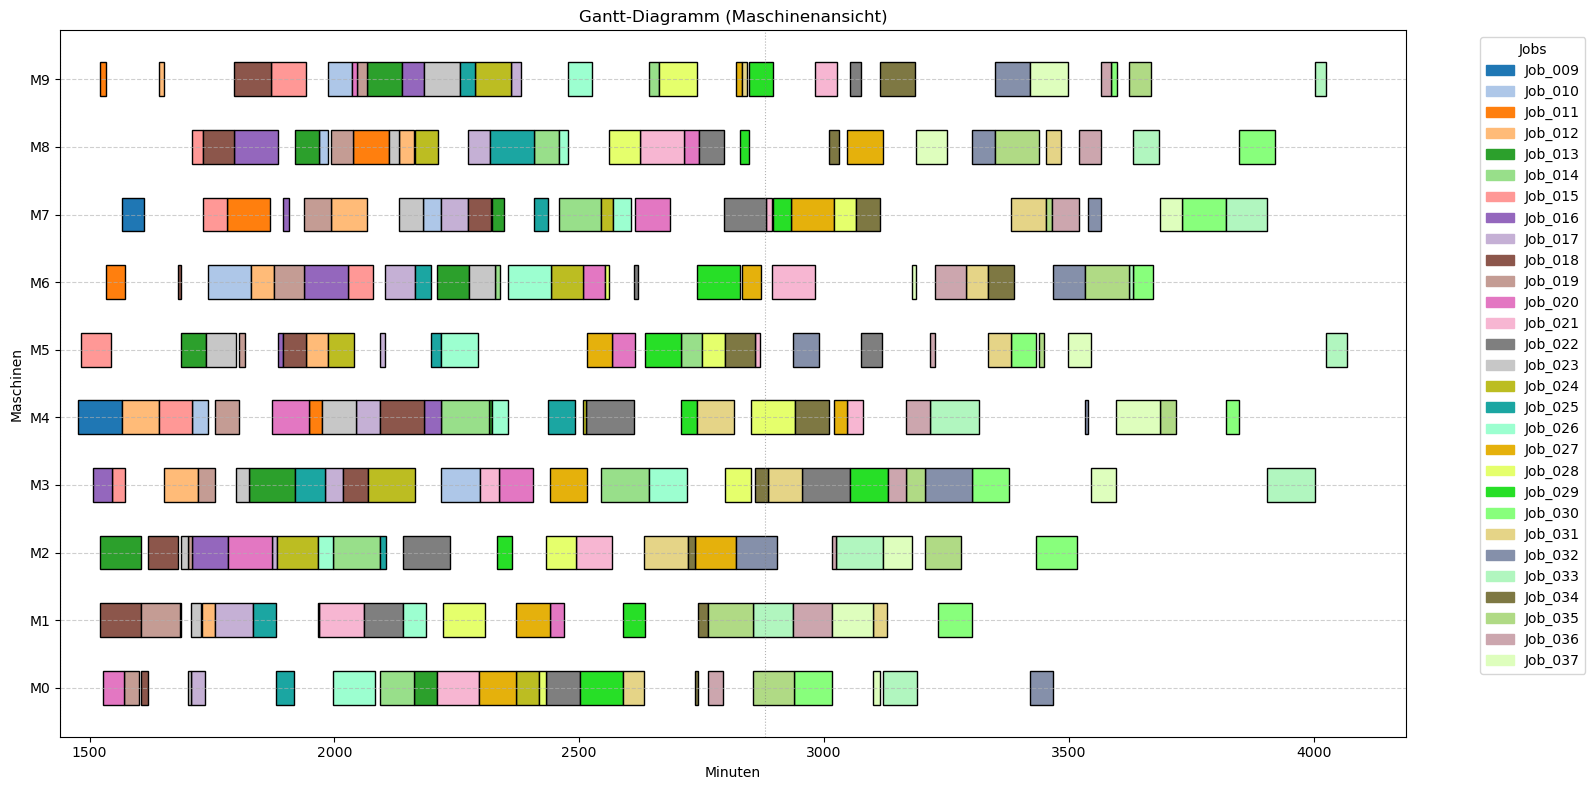

✅ Keine Maschinenkonflikte gefunden
❌ Fehler in der Operationssequenz bei 7 Job(s):
  Job 'Job_009': erwartet Indizes [0, 1], gefunden [8, 9]
  Job 'Job_010': erwartet Indizes [0, 1, 2, 3, 4, 5], gefunden [4, 5, 6, 7, 8, 9]
  Job 'Job_011': erwartet Indizes [0, 1, 2, 3, 4], gefunden [5, 6, 7, 8, 9]
  Job 'Job_012': erwartet Indizes [0, 1, 2, 3, 4, 5, 6, 7], gefunden [2, 3, 4, 5, 6, 7, 8, 9]
  Job 'Job_014': erwartet Indizes [0, 1, 2, 3, 4, 5, 6, 7, 8], gefunden [1, 2, 3, 4, 5, 6, 7, 8, 9]
  Job 'Job_015': erwartet Indizes [0, 1, 2, 3, 4, 5, 6], gefunden [3, 4, 5, 6, 7, 8, 9]
  Job 'Job_016': erwartet Indizes [0, 1, 2, 3, 4, 5, 6, 7], gefunden [2, 3, 4, 5, 6, 7, 8, 9]
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

❗ Es wurden Constraint-Verletzungen gefunden.



False

In [19]:
show.plot_gantt_machines(df_reschedule)
check.check_all_constraints(df_reschedule)

### Export

In [20]:
df_plan.to_csv("data/03a_origininal_schedule.csv", index = False)
df_execution.to_csv("data/03b_schedule_simulation.csv", index = False)
df_reschedule.to_csv("data/03c_new_schedule.csv", index = False)

In [21]:
df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

df_schedule_mix = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_schedule_mix = df_schedule_mix.sort_values(by="Start").reset_index(drop=True)
df_schedule_mix

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,11.28,11.28,11.28
1,Job_000,1,0.00,M1,29.00,63.75,92.75,92.75
2,Job_001,0,88.05,M0,88.05,33.97,33.97,122.02
3,Job_000,2,0.00,M2,107.00,6.00,113.00,113.00
4,Job_000,3,0.00,M3,116.00,52.74,168.74,168.74
...,...,...,...,...,...,...,...,...
375,Job_033,6,2630.89,M7,3820.61,85.00,1274.72,3905.61
376,Job_030,9,2384.71,M8,3846.61,74.00,1535.90,3920.61
377,Job_033,7,2630.89,M3,3905.61,98.00,1372.72,4003.61
378,Job_033,8,2630.89,M9,4003.61,22.00,1394.72,4025.61


In [22]:
df_schedule_mix.to_csv("data/03d_new_schedule_complete.csv", index = False)